In [1]:
import os
import gc
import time
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from multiprocessing import Pool
import lightgbm as lgb
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
      ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])

available GPU devices: 1  | device num: 0


In [2]:
SEED = 80
DATA_DIR = './data'
MODELS_DIR = './models'
MODEL_VER = 'v0'
CUT_DATE = '2011-01-01'
END_D = 1913
PRED_FWD = 28
N_CORES = int(psutil.cpu_count() * .75)
print('num pf cores:', N_CORES)
#---|CUT_DATE|---train---|END_D - PRED_FWD|--val--|END_D|--forecast-->|END_D + PRED_FWD|

num pf cores: 24


In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int8', 
    'month':            'int8', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int8', 
    'snap_TX':          'int8', 
    'snap_WI':          'int8'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float16'
}
DROP_COLS = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday']
CAT_COLS = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]

In [4]:
def get_df():
    start_time = time.time()
    print('-' * 10, 'BASE GRID', '-' * 10)
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    for day in range(END_D + 1, END_D + PRED_FWD + 1):
        strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    strain.drop(columns=['month', 'year'], inplace=True)
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('calendar merge done:', strain.shape)
    strain['tm_d'] = strain['date'].dt.day.astype(np.int8)
    strain['tm_w'] = strain['date'].dt.week.astype(np.int8)
    strain['tm_m'] = strain['date'].dt.month.astype(np.int8)
    strain['tm_y'] = strain['date'].dt.year
    strain['tm_y'] = (strain['tm_y'] - strain['tm_y'].min()).astype(np.int8)
    strain['tm_wm'] = strain['tm_d'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    strain['tm_dw'] = strain['date'].dt.dayofweek.astype(np.int8)
    strain['tm_w_end'] = (strain['tm_dw'] >= 5).astype(np.int8)
    print('date features done')
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    sprices['price_max'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('max')
    sprices['price_min'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('min')
    sprices['price_std'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('std')
    sprices['price_mean'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')
    sprices['price_norm'] = sprices['sell_price'] / sprices['price_max']
    sprices['price_nunique'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('nunique')
    sprices['item_nunique'] = sprices.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')
    calendar_prices = calendar[['wm_yr_wk', 'month', 'year']]
    calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
    sprices = sprices.merge(calendar_prices[['wm_yr_wk', 'month', 'year']], on=['wm_yr_wk'], how='left')
    del calendar, calendar_prices
    sprices['price_momentum'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id']
    )['sell_price'].transform(lambda x: x.shift(1))
    sprices['price_momentum_m'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'month']
    )['sell_price'].transform('mean')
    sprices['price_momentum_y'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'year']
    )['sell_price'].transform('mean')
    strain = strain.merge(sprices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    strain.drop(columns=['month', 'year'], inplace=True)
    del sprices
    strain['lag_price_1'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    strain['price_change_1'] = (strain['lag_price_1']-strain['sell_price']) / strain['lag_price_1']
    strain['roll_price_max_365'] = strain.groupby(['id'])['sell_price'].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    strain['price_change_365'] = (strain['roll_price_max_365']-strain['sell_price']) / strain['roll_price_max_365']
    strain['roll_price_std_7'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    strain['roll_price_std_30'] = strain.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    print('prices features and merge done:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    for col in CAT_COLS:
        strain[col]= strain[col].astype('category')
        strain[col] = strain[col].cat.codes.astype('int16')
        strain[col] -= strain[col].min()
    print('cols to category done:', strain.shape)
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    gc.collect()
    return strain

In [5]:
def make_features_adv(strain):
    start_time = time.time()
    print('-' * 10, 'ADVANCED FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    icols =  [
        ['state_id'],
        ['store_id'],
        ['cat_id'],
        ['dept_id'],
        ['state_id', 'cat_id'],
        ['state_id', 'dept_id'],
        ['store_id', 'cat_id'],
        ['store_id', 'dept_id'],
        ['item_id'],
        ['item_id', 'state_id'],
        ['item_id', 'store_id']
    ]
    cols = list(set([item for sublist in icols for item in sublist]))
    cols.extend(['d', 'sales'])
    df_temp = strain[cols].copy()
    df_temp.loc[df_temp['d'] > (END_D - PRED_FWD), 'sales'] = np.nan
    for col in icols:
        col_name = '_{}_'.format('_'.join(col))
        strain['enc{}mean'.format(col_name)] = df_temp.groupby(col)['sales'].transform('mean').astype(np.float16)
        strain['enc{}std'.format(col_name)] = df_temp.groupby(col)['sales'].transform('std').astype(np.float16)
    print('encoding done')
    del df_temp
    gc.collect()
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [6]:
def make_features_lag(strain):
    start_time = time.time()
    print('-' * 10, 'LAG AND ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = range(PRED_FWD, PRED_FWD + 14 + 1)
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby(['id'])['sales'].shift(lag).astype(np.float16)
    print('lag sales done')
    for roll in [7, 14, 30, 60, 180]:
        roll_col = 'lag_{}_roll_mean_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).mean()
        ).astype(np.float16)
        roll_col = 'lag_{}_roll_std_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).std()
        ).astype(np.float16)
    print('roll mean and std sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [7]:
def make_features_last_sales(strain):
    start_time = time.time()
    print('-' * 10, 'LAST SALES FEATURE', '-' * 10)
    print('in dataframe:', strain.shape)
    n_day = 1    
    last_sales = strain[['id', 'd', 'sales']].copy()
    last_sales['non_zero'] = (last_sales['sales'] > 0).astype(np.int8)
    last_sales['non_zero_lag'] = last_sales.groupby(['id'])['non_zero'].transform(
        lambda x: x.shift(n_day).rolling(2000, 1).sum()
    ).fillna(-1)
    df_temp = last_sales[['id', 'd', 'non_zero_lag']].drop_duplicates(subset=['id', 'non_zero_lag'])
    df_temp.columns = ['id', 'd_min', 'non_zero_lag']
    last_sales = last_sales.merge(df_temp, on=['id', 'non_zero_lag'], how='left')
    strain.loc[:, 'last_sale'] = (last_sales['d'] - last_sales['d_min']).astype(np.int16)
    del last_sales, df_temp
    gc.collect()
    print('last non zero sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [8]:
def make_features_win(strain):
    start_time = time.time()
    print('-' * 10, 'WIN ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = [1, 7, 14]
    windows= [7, 14, 30, 60]
    for lag in lags:
        for wnd in windows:
            wnd_col = 'lag_{}_roll_mean_{}'.format(lag, wnd)
            strain[wnd_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
                lambda x: x.shift(lag).rolling(wnd).mean().astype(np.float16)
            )
    print('window roll mean sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [9]:
%%time
strain = get_df()
strain = make_features_adv(strain)
strain = make_features_lag(strain)
strain = make_features_last_sales(strain)
strain = make_features_win(strain)

---------- BASE GRID ----------
read train: (30490, 1919)
melted train: (59181090, 8)
read calendar: (1969, 14)
calendar merge done: (59181090, 19)
date features done
time elapsed: 2 min 8 sec
read prices: (6841121, 4)
prices features and merge done: (59181090, 43)
time elapsed: 4 min 50 sec
cols to category done: (59181090, 43)
begin train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
date cut train: (59181090, 43)
cut train date: 2011-01-29 00:00:00
end train date: 2016-05-22 00:00:00
time elapsed: 5 min 29 sec
---------- ADVANCED FEATURES ----------
in dataframe: (59181090, 43)
encoding done
time elapsed: 0 min 34 sec
---------- LAG AND ROLL FEATURES ----------
in dataframe: (59181090, 65)
lag sales done
roll mean and std sales done
out dataframe: (59181090, 90)
time elapsed: 5 min 54 sec
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 90)
last non zero sales done
out dataframe: (59181090, 91)
time elapsed: 0 min 50 sec
---------- WIN ROLL FEATURES 

from 2011-01-29 00:00:00 to 2016-05-22 00:00:00


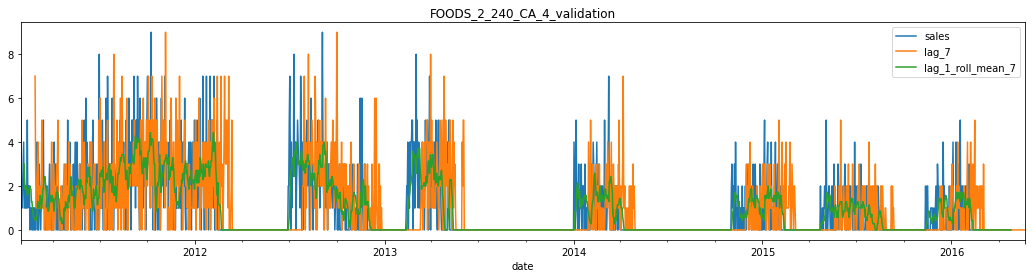

In [10]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_28'].plot(label='lag_7')
id_sales['lag_1_roll_mean_7'].plot(label='lag_1_roll_mean_7')
plt.title(id_name)
plt.legend()
plt.show()

In [11]:
train_cols = strain.columns[~strain.columns.isin(DROP_COLS)]
store_ids = list(strain['store_id'].unique())
print('stores:', store_ids)

stores: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': .5,
    'subsample_freq': 1,
    'learning_rate': .03,
    'num_leaves': 2 ** 11 - 1,
    'min_data_in_leaf': 2 ** 12 - 1,
    'feature_fraction': .5,
    'max_bin': 100,
    'n_estimators': 5000,
    'boost_from_average': False,
    'verbose': 1,
    'nthread' : N_CORES,
    'early_stopping_rounds': 100,
    'lambda_l2': 1,
    'seed': SEED
}
for store_id in tqdm(store_ids):
    print('-' * 10, 'store training:', store_id, '-' * 10)
    X_train = strain[
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ][train_cols]
    y_train = strain[
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ]['sales']
    X_val = strain[
        (strain['d'] > (END_D - PRED_FWD)) & 
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ][train_cols]
    y_val = strain[
        (strain['d'] > (END_D - PRED_FWD)) & 
        (strain['d'] <= END_D) &
        (strain['store_id'] == store_id)
    ]['sales']
    print('train shapes:', X_train.shape, len(y_train))
    print('val shapes:', X_val.shape, len(y_val))
    train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_COLS, free_raw_data=False)
    val_lgb = lgb.Dataset(X_val, label=y_val, categorical_feature=CAT_COLS, free_raw_data=False)
    del X_train, y_train, X_val, y_val
    gc.collect()
    model = lgb.train(lgb_params, train_lgb, valid_sets=[val_lgb], verbose_eval=100) 
    model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
    model.save_model(model_file)
    print('save to file:', model_file)

---------- store training: 0 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372


/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/envs/mrorangeenv/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.02255
[200]	valid_0's rmse: 2.01315
[300]	valid_0's rmse: 1.99683
[400]	valid_0's rmse: 1.98635
[500]	valid_0's rmse: 1.97626
[600]	valid_0's rmse: 1.96765
[700]	valid_0's rmse: 1.96037
[800]	valid_0's rmse: 1.95424
[900]	valid_0's rmse: 1.94885
[1000]	valid_0's rmse: 1.94333
[1100]	valid_0's rmse: 1.93778
[1200]	valid_0's rmse: 1.93228
[1300]	valid_0's rmse: 1.9263
[1400]	valid_0's rmse: 1.92059
[1500]	valid_0's rmse: 1.91553
[1600]	valid_0's rmse: 1.91077
[1700]	valid_0's rmse: 1.90585
[1800]	valid_0's rmse: 1.90132
[1900]	valid_0's rmse: 1.89632
[2000]	valid_0's rmse: 1.89162
[2100]	valid_0's rmse: 1.88771
[2200]	valid_0's rmse: 1.88228
[2300]	valid_0's rmse: 1.8774
[2400]	valid_0's rmse: 1.87413
[2500]	valid_0's rmse: 1.87025
[2600]	valid_0's rmse: 1.86553
[2700]	valid_0's rmse: 1.86164
[2800]	valid_0's rmse: 1.85817
[2900]	valid_0's rmse: 1.85404
[3000]	valid_0's rmse: 1.84883
[3100]	valid_0's rm

[2800]	valid_0's rmse: 1.4851
[2900]	valid_0's rmse: 1.48109
[3000]	valid_0's rmse: 1.4779
[3100]	valid_0's rmse: 1.47379
[3200]	valid_0's rmse: 1.47066
[3300]	valid_0's rmse: 1.46752
[3400]	valid_0's rmse: 1.4652
[3500]	valid_0's rmse: 1.46216
[3600]	valid_0's rmse: 1.45843
[3700]	valid_0's rmse: 1.45478
[3800]	valid_0's rmse: 1.45162
[3900]	valid_0's rmse: 1.44809
[4000]	valid_0's rmse: 1.44506
[4100]	valid_0's rmse: 1.44146
[4200]	valid_0's rmse: 1.43927
[4300]	valid_0's rmse: 1.43642
[4400]	valid_0's rmse: 1.43318
[4500]	valid_0's rmse: 1.42993
[4600]	valid_0's rmse: 1.42707
[4700]	valid_0's rmse: 1.42402
[4800]	valid_0's rmse: 1.42168
[4900]	valid_0's rmse: 1.41857
[5000]	valid_0's rmse: 1.41491
Did not meet early stopping. Best iteration is:
[4997]	valid_0's rmse: 1.41487
save to file: ./models/model_v0_store_4.lgb
---------- store training: 5 ----------
train shapes: (5832737, 97) 5832737
val shapes: (85372, 97) 85372
Training until validation scores don't improve for 100 rounds

In [13]:
store_id = 0
model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
model = lgb.Booster(model_file=model_file)

In [14]:
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, model.feature_importance())],
    key=lambda x: x[1],
    reverse=True
)

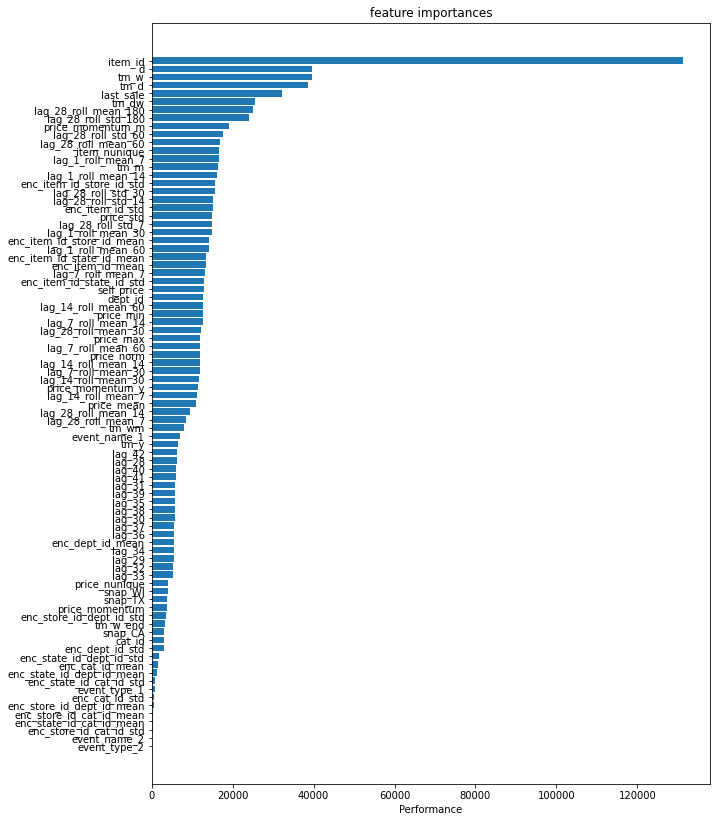

In [15]:
fig, ax = plt.subplots(figsize=(10, 14))
labels, values = [x[0] for x in feat_importances if x[1] > .5], [x[1] for x in feat_importances if x[1] > .5]
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [16]:
%%time
spred = strain[
    (strain['d'] > (END_D - PRED_FWD)) &
    (strain['d'] <= END_D) &
    (strain['store_id'] == store_id)
].copy()
preds = model.predict(spred[train_cols])
print(len(preds))
spred.loc[:, 'sales'] = preds

85372
CPU times: user 5min 6s, sys: 64 ms, total: 5min 6s
Wall time: 12.9 s


id to draw: FOODS_1_103_CA_1_validation


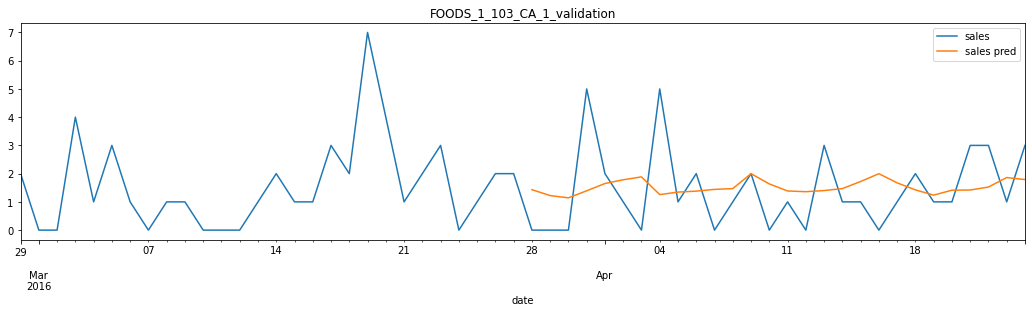

In [17]:
id_name = np.random.choice(strain[strain['store_id'] == store_id]['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - 2 * PRED_FWD)) &
    (strain['d'] <= END_D) &
    (strain['store_id'] == store_id)
].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales pred')
plt.title(id_name)
plt.legend()
plt.show()

In [19]:
for pred_d in tqdm(range(1, PRED_FWD + 1)):
    print('=' * 10, 'forecast day forward:', pred_d, '=' * 10) 
    strain = make_features_last_sales(strain)
    spred = strain[strain['d'] > (END_D - 100)].copy()
    spred = make_features_win(spred)
    for store_id in store_ids:
        model_file = '{}/model_{}_store_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id)
        model = lgb.Booster(model_file=model_file)
        strain.loc[
            (strain['d'] == (END_D + pred_d)) & (strain['store_id'] == store_id), 
            'sales'
        ] = model.predict(
            spred.loc[
                (spred['d'] == (END_D + pred_d)) & (spred['store_id'] == store_id), 
                train_cols
            ]
        )
        print('store predicted:', store_id, '| model:', model_file)
    all_sales = strain[strain['d'] == (END_D + pred_d)]['sales'].values
    print('day forward:', END_D + pred_d, 'all sales:', np.sum(all_sales))

========== forecast day forward: 1 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 97)
last non zero sales done
out dataframe: (59181090, 97)
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 97)
window roll mean sales done
out dataframe: (3902720, 97)
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1914 all sales: 37625.6804897203
========== forecast day forward: 2 ==========
---------- LAST SALES FEATURE --

store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1922 all sales: 45494.5283245062
========== forecast day forward: 10 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 97)
last non zero sales done
out dataframe: (59181090, 97)
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 97)
window roll mean sales done
out dataframe: (3902720, 97)
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1923 a

store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1931 all sales: 41705.011532637065
========== forecast day forward: 19 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 97)
last non zero sales done
out dataframe: (59181090, 97)
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 97)
window roll mean sales done
out dataframe: (3902720, 97)
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 

store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 6 | model: ./models/model_v0_store_6.lgb
store predicted: 7 | model: ./models/model_v0_store_7.lgb
store predicted: 8 | model: ./models/model_v0_store_8.lgb
store predicted: 9 | model: ./models/model_v0_store_9.lgb
day forward: 1940 all sales: 51519.399775618265
========== forecast day forward: 28 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (59181090, 97)
last non zero sales done
out dataframe: (59181090, 97)
---------- WIN ROLL FEATURES ----------
in dataframe: (3902720, 97)
window roll mean sales done
out dataframe: (3902720, 97)
store predicted: 0 | model: ./models/model_v0_store_0.lgb
store predicted: 1 | model: ./models/model_v0_store_1.lgb
store predicted: 2 | model: ./models/model_v0_store_2.lgb
store predicted: 3 | model: ./models/model_v0_store_3.lgb
store predicted: 4 | model: ./models/model_v0_store_4.lgb
store predicted: 5 | model: ./models/model_v0_store_5.lgb
store predicted: 

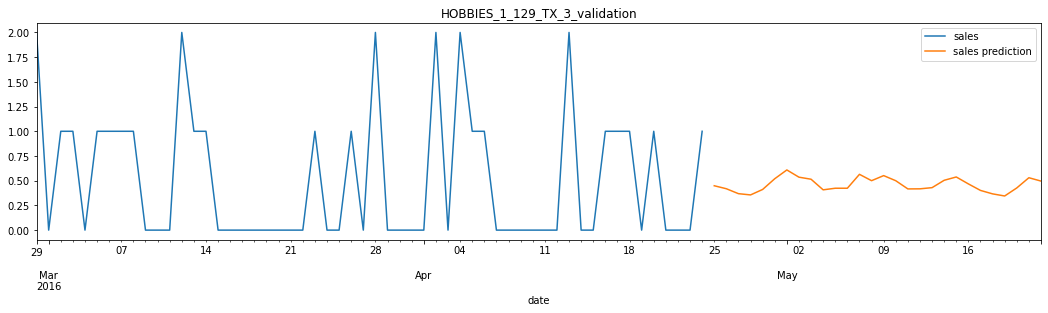

In [20]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - 2 * PRED_FWD)) &
    (strain['d'] <= END_D)
].set_index('date')
id_sales_pred = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > END_D)
].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [21]:
spred_subm = strain.loc[strain['d'] > END_D, ['id', 'd', 'sales']].copy()
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(x - END_D))
spred_subm.loc[spred_subm['sales'] < 0, 'sales'] = 0

In [22]:
f_cols = ['F{}'.format(x) for x in range(1, PRED_FWD + 1)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.723987,0.694339,0.667491,0.693766,0.852776,0.872878,0.957418,0.798669,0.822283,0.903244,0.863975,0.997937,1.005065,0.843089,0.849267,0.730657,0.756663,0.699403,0.797248,0.851072,0.841834,0.684066,0.694935,0.612559,0.611684,0.695041,0.814525,0.711313
1,FOODS_1_001_CA_2_validation,1.026147,1.046447,0.934361,0.869065,1.063278,1.182977,1.557769,0.991629,1.214643,1.041476,1.214081,1.209299,1.353813,1.358628,0.939598,0.963147,1.026420,0.976347,1.163429,1.373397,1.323456,0.944349,1.071724,0.857428,0.968391,0.920872,1.293214,1.291512
2,FOODS_1_001_CA_3_validation,0.774062,1.068432,0.978926,0.877117,0.995489,1.413415,1.316042,0.868483,0.858272,0.789115,0.854047,1.078375,1.296525,1.354212,0.861199,0.801042,0.857424,0.764300,1.002859,1.447558,1.518514,0.804170,0.829742,0.945366,0.905029,1.102597,1.369586,1.416303
3,FOODS_1_001_CA_4_validation,0.350336,0.334892,0.310457,0.310062,0.318452,0.357102,0.347798,0.393167,0.322528,0.355343,0.354289,0.335743,0.397427,0.405813,0.405694,0.376894,0.377530,0.351312,0.366854,0.385237,0.336079,0.332248,0.299048,0.330308,0.345835,0.300969,0.345222,0.370089
4,FOODS_1_001_TX_1_validation,0.064709,0.450356,0.465927,0.443333,0.512168,0.504469,0.582288,0.376339,0.512137,0.452365,0.458347,0.499033,0.496206,0.574046,0.454166,0.513691,0.477385,0.501053,0.480969,0.498491,0.465203,0.443594,0.429248,0.386143,0.399563,0.401411,0.430285,0.447595


In [23]:
spred_subm_eval = spred_subm.copy()
spred_subm_eval['id'] = spred_subm_eval['id'].str.replace('validation', 'evaluation')
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('submission.csv', index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)
